In [1]:
# Importing Necesasary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import joblib
from tqdm import tqdm
import time

import shap
import warnings
warnings.filterwarnings('ignore')

D:\File\Conda\envs\data-science\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Reading the Dataset
df = pd.read_csv("G:\My Drive\ITS\Tugas\Semester_5\Biomedical Engineering\Final Project Req\Dataset.csv")

In [4]:
# Handling Missing Values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
# Label Targeting and Feature Selection
label = df.columns[-1]
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_cols = [c for c in numeric_cols if c != label]

# Preparing Feature Matrix and Target Vector
X = df[feature_cols].values
y_raw = df[label].values

# Label Encoding the Target Variable
le = LabelEncoder()
y = le.fit_transform(df[label])

In [6]:
# Splitting the Dataset into Training and Val-Test Sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

# Further Splitting Val-Test Set into Validation and Test Sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                y_val_test,
                                                test_size=0.5,
                                                stratify=y_val_test,
                                                random_state=42)

In [7]:
# Checking class distribution of each set
from collections import Counter

print("Training set class distribution:", Counter(y_train))
print("\nValidation set class distribution:", Counter(y_val))
print("\nTest set class distribution:", Counter(y_test))

Training set class distribution: Counter({np.int64(2): 304, np.int64(3): 136, np.int64(0): 99, np.int64(4): 83, np.int64(1): 47})

Validation set class distribution: Counter({np.int64(2): 65, np.int64(3): 29, np.int64(0): 21, np.int64(4): 18, np.int64(1): 10})

Test set class distribution: Counter({np.int64(2): 65, np.int64(3): 29, np.int64(0): 22, np.int64(4): 18, np.int64(1): 10})


In [8]:
# Feature Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [9]:
print("Training set shape:")
print("Shape of X_Train:", X_train.shape)
print("Shape of y_Train:", y_train.shape)

print("\nValidation set shape:")
print("Shape of X_Val:", X_val.shape)
print("Shape of y_Val:", y_val.shape)

print("\nTest set shape:")
print("Shape of X_Test:", X_test.shape)
print("Shape of y_Test:", y_test.shape)


Training set shape:
Shape of X_Train: (669, 20530)
Shape of y_Train: (669,)

Validation set shape:
Shape of X_Val: (143, 20530)
Shape of y_Val: (143,)

Test set shape:
Shape of X_Test: (144, 20530)
Shape of y_Test: (144,)


In [10]:
# Enable verbose output for LogisticRegression
lasso = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=0.1,
    max_iter=5000,
    n_jobs=-1,
    verbose=1
)

# Wrap the fit method with tqdm for progress bar
print("Training Lasso Logistic Regression...")
start_time = time.time()
lasso.fit(X_train_scaled, y_train)
elapsed_time = time.time() - start_time
print(f"Training completed in {elapsed_time / 60:.2f} minutes.")

lasso_coef = np.mean(np.abs(lasso.coef_), axis=0)
lasso_rank_idx = np.argsort(lasso_coef)[::-1]
lasso_genes = []
for i in tqdm(lasso_rank_idx, desc="Ranking features"):
    lasso_genes.append(feature_cols[i])


Training Lasso Logistic Regression...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
D:\File\Conda\envs\data-science\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 1828 seconds
Training completed in 1827.82 seconds


Ranking features: 100%|██████████| 20530/20530 [00:00<00:00, 2361805.35it/s]


In [13]:
# Save the model to the specified path
joblib.dump(lasso, 'Saved Model/lasso_logistic_model.pkl')

['Saved Model/lasso_logistic_model.pkl']

In [2]:
lasso = joblib.load('Saved Model/lasso_logistic_model.pkl')

In [10]:
y_train_pred = lasso.predict(X_train)
y_val_pred = lasso.predict(X_val)

print("\nTraining Accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))


Training Accuracy: 1.0
Validation Accuracy: 0.8881118881118881

Classification Report (Validation):
              precision    recall  f1-score   support

       Basal       1.00      0.95      0.98        21
        Her2       1.00      0.70      0.82        10
        LumA       0.87      0.92      0.90        65
        LumB       0.79      0.76      0.77        29
      Normal       0.95      1.00      0.97        18

    accuracy                           0.89       143
   macro avg       0.92      0.87      0.89       143
weighted avg       0.89      0.89      0.89       143



In [11]:
# Get feature coefficients and their importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lasso.coef_[0],
    'abs_coefficient': np.abs(lasso.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

Top 10 Most Important Features:
       feature  coefficient  abs_coefficient
9538     FABP7     0.049893         0.049893
16648   ABCC11    -0.046319         0.046319
8801   HORMAD1     0.045857         0.045857
17107  CEACAM5    -0.045192         0.045192
18032  CXorf61     0.043413         0.043413
10784     MSLN     0.038449         0.038449
12823    ROPN1     0.034920         0.034920
195       ART3     0.030813         0.030813
18492    VGLL1     0.030169         0.030169
8074       CA9     0.029272         0.029272


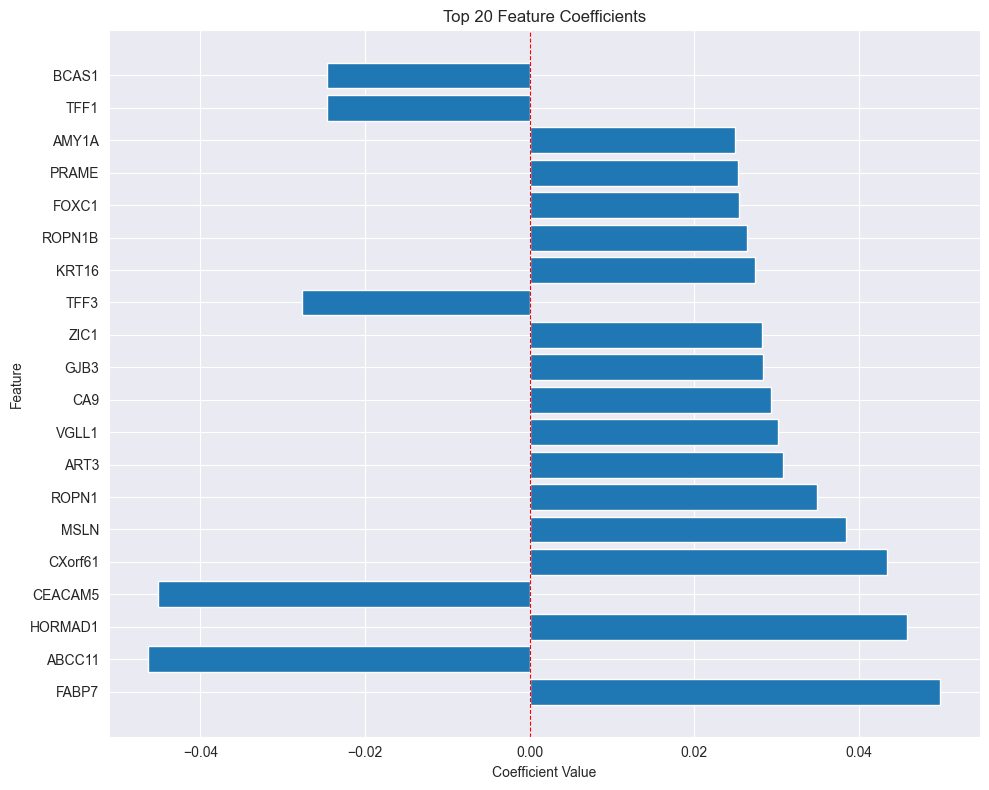

In [12]:
# Plot top 20 feature coefficients
top_n = 20
top_features = feature_importance.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'], top_features['coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Coefficients')
plt.axvline(x=0, color='red', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

In [13]:
# Calculate odds ratios for better interpretation
odds_ratios = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lasso.coef_[0],
    'odds_ratio': np.exp(lasso.coef_[0])
}).sort_values('odds_ratio', ascending=False)

print("\nOdds Ratios (exp(coefficient)):")
print(odds_ratios.head(10))
print("\nInterpretation: OR > 1 increases probability, OR < 1 decreases probability")


Odds Ratios (exp(coefficient)):
       feature  coefficient  odds_ratio
9538     FABP7     0.049893    1.051158
8801   HORMAD1     0.045857    1.046925
18032  CXorf61     0.043413    1.044369
10784     MSLN     0.038449    1.039198
12823    ROPN1     0.034920    1.035537
195       ART3     0.030813    1.031293
18492    VGLL1     0.030169    1.030629
8074       CA9     0.029272    1.029705
11871     GJB3     0.028320    1.028725
5629      ZIC1     0.028192    1.028593

Interpretation: OR > 1 increases probability, OR < 1 decreases probability


In [14]:
# Show how the model makes decisions
def explain_prediction(sample_idx):
    sample = X_val[sample_idx].reshape(1, -1)
    prediction = lasso.predict(sample)[0]
    proba = lasso.predict_proba(sample)[0]

    # Calculate contribution of each feature
    contributions = sample[0] * lasso.coef_[0]
    contrib_df = pd.DataFrame({
        'feature': feature_cols,
        'value': sample[0],
        'coefficient': lasso.coef_[0],
        'contribution': contributions
    }).sort_values('contribution', key=abs, ascending=False)

    print(f"Prediction: {le.inverse_transform([prediction])[0]}")
    print(f"Probability: {proba}")
    print("\nTop 10 Contributing Features:")
    print(contrib_df.head(10))

explain_prediction(0)  # Explain first validation sample

Prediction: Normal
Probability: [0.0845466  0.04040477 0.37027679 0.01917081 0.48560104]

Top 10 Contributing Features:
       feature    value  coefficient  contribution
9538     FABP7   7.1168     0.049893      0.355078
16648   ABCC11   7.3286    -0.046319     -0.339455
17107  CEACAM5   6.5504    -0.045192     -0.296026
19117    PRAME  11.1812     0.025318      0.283087
16590     TFF3   9.4802    -0.027702     -0.262620
13725  SCGB2A2  12.6028    -0.017919     -0.225830
1212    C4orf7   9.2477     0.023922      0.221221
4713     FOXC1   8.2412     0.025484      0.210020
9867     BCAS1   8.1146    -0.024614     -0.199729
18492    VGLL1   6.2445     0.030169      0.188392


In [15]:
# Analyze top contributing features for each class
n_top_features = 10

for class_idx, class_name in enumerate(le.classes_):
    print(f"\n{'='*60}")
    print(f"Class: {class_name}")
    print('='*60)

    # Get coefficients for this class
    class_coef = lasso.coef_[class_idx]

    # Create DataFrame with features and their coefficients
    class_features = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': class_coef,
        'abs_coefficient': np.abs(class_coef)
    }).sort_values('abs_coefficient', ascending=False)

    print(f"\nTop {n_top_features} Contributing Features:")
    print(class_features.head(n_top_features).to_string(index=False))

    # Show positive and negative contributors separately
    positive_features = class_features[class_features['coefficient'] > 0].head(5)
    negative_features = class_features[class_features['coefficient'] < 0].head(5)

    print(f"\nTop 5 Positive Contributors (increase probability):")
    print(positive_features[['feature', 'coefficient']].to_string(index=False))

    print(f"\nTop 5 Negative Contributors (decrease probability):")
    print(negative_features[['feature', 'coefficient']].to_string(index=False))


Class: Basal

Top 10 Contributing Features:
feature  coefficient  abs_coefficient
  FABP7     0.049893         0.049893
 ABCC11    -0.046319         0.046319
HORMAD1     0.045857         0.045857
CEACAM5    -0.045192         0.045192
CXorf61     0.043413         0.043413
   MSLN     0.038449         0.038449
  ROPN1     0.034920         0.034920
   ART3     0.030813         0.030813
  VGLL1     0.030169         0.030169
    CA9     0.029272         0.029272

Top 5 Positive Contributors (increase probability):
feature  coefficient
  FABP7     0.049893
HORMAD1     0.045857
CXorf61     0.043413
   MSLN     0.038449
  ROPN1     0.034920

Top 5 Negative Contributors (decrease probability):
feature  coefficient
 ABCC11    -0.046319
CEACAM5    -0.045192
   TFF3    -0.027702
   TFF1    -0.024632
  BCAS1    -0.024614

Class: Her2

Top 10 Contributing Features:
 feature  coefficient  abs_coefficient
    CPB1    -0.077318         0.077318
    PNMT     0.064642         0.064642
   NXPH1     0.060

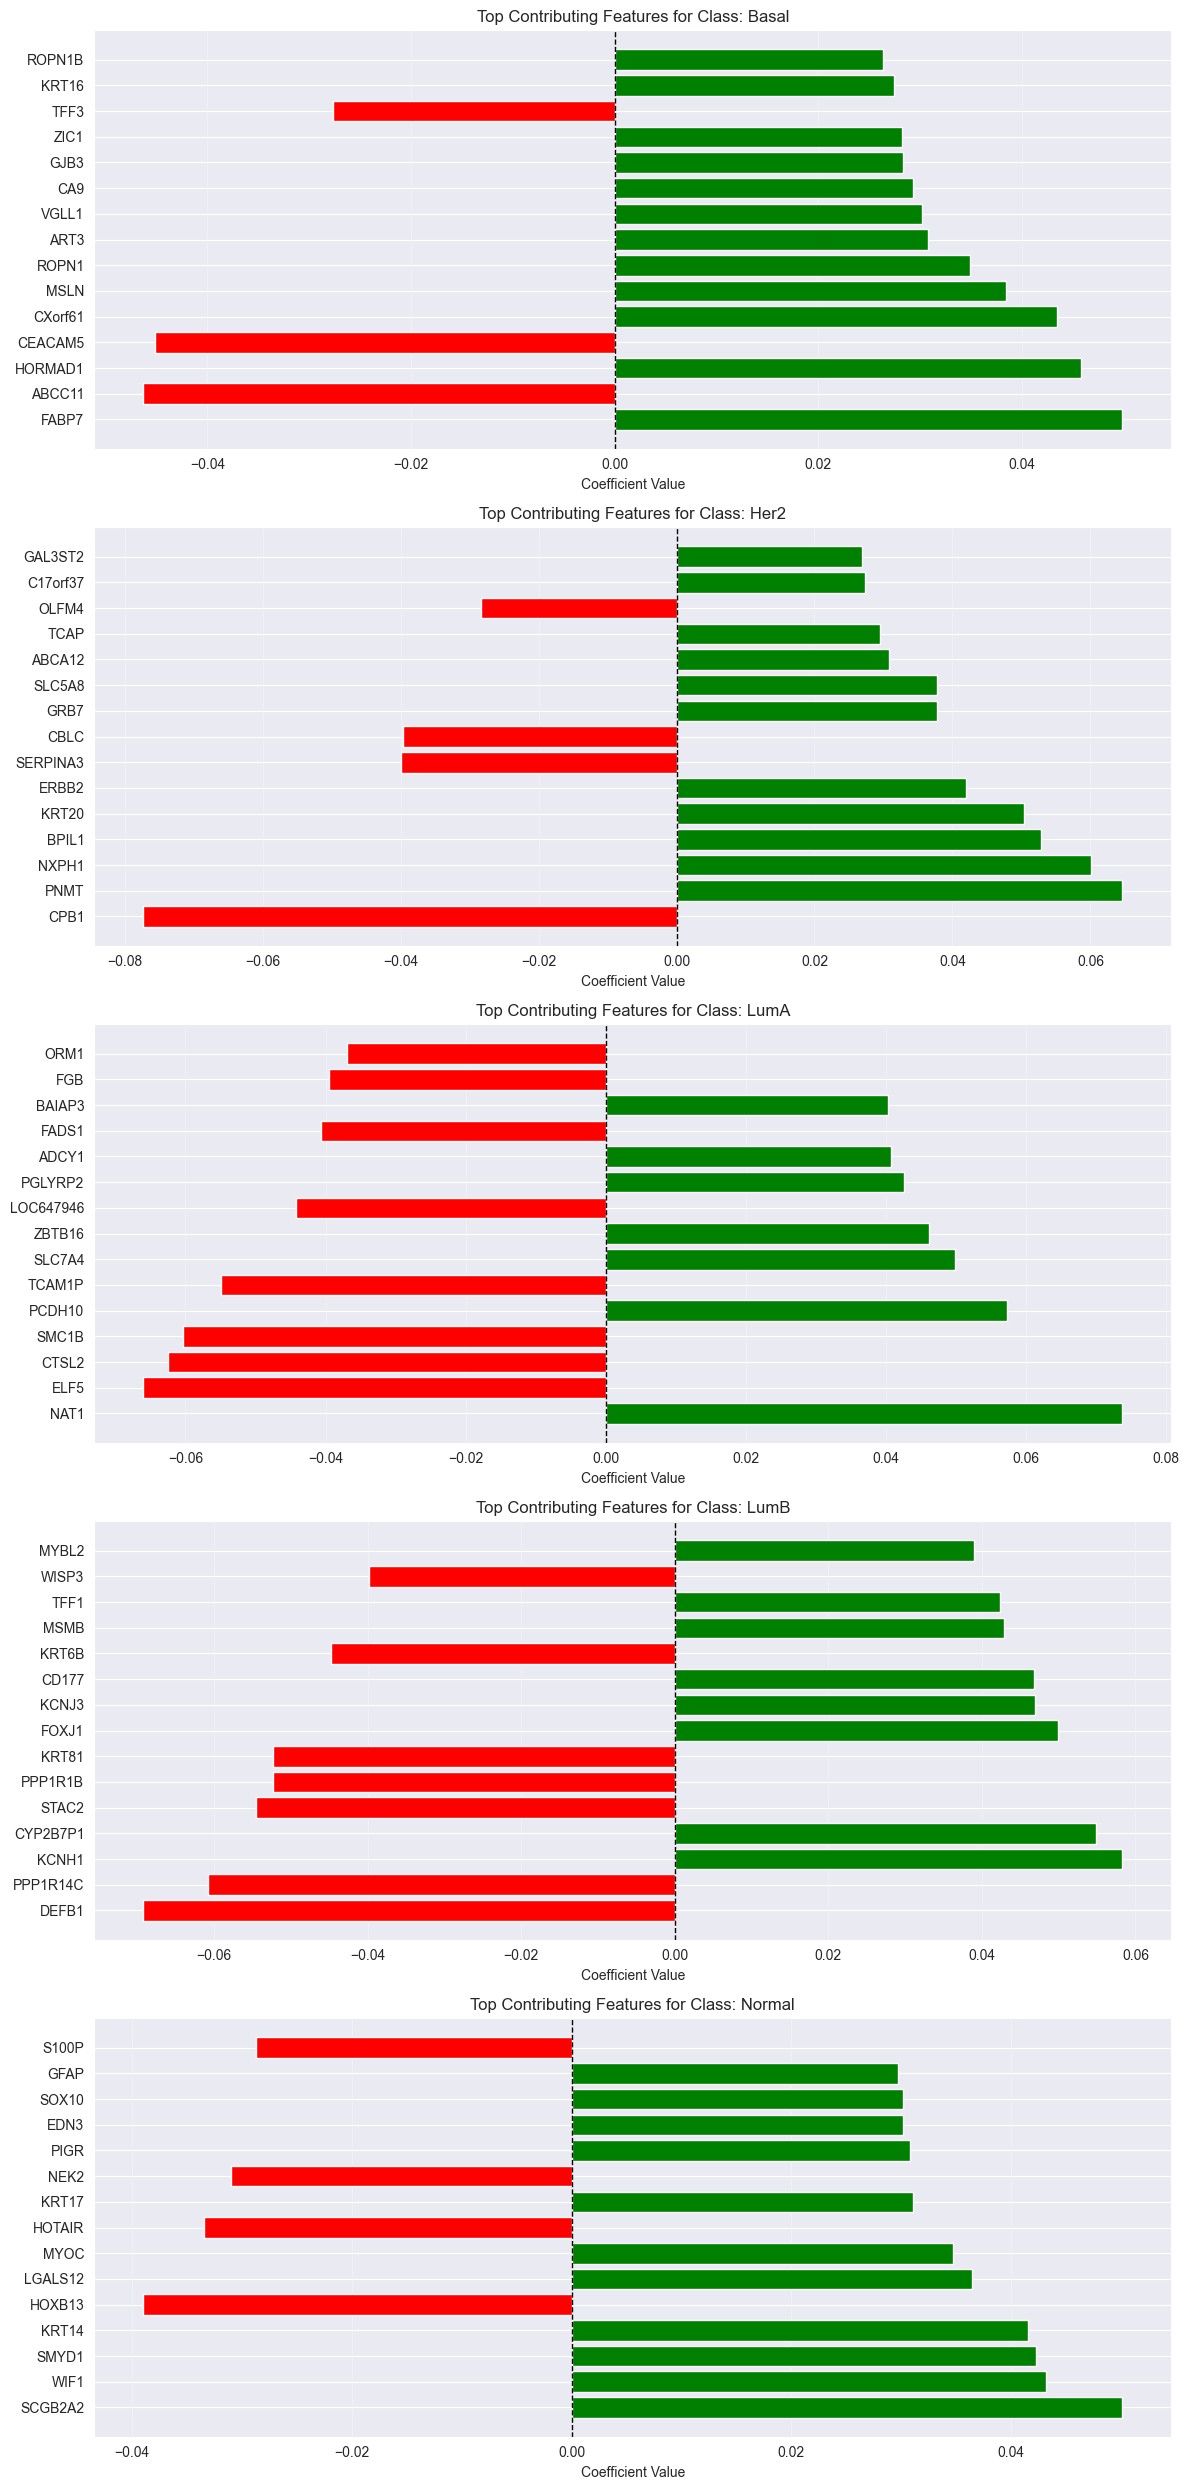

In [16]:
# Visualize top features for each class
n_classes = len(le.classes_)
fig, axes = plt.subplots(n_classes, 1, figsize=(12, 5*n_classes))

if n_classes == 1:
    axes = [axes]

for class_idx, class_name in enumerate(le.classes_):
    class_coef = lasso.coef_[class_idx]

    # Get top features by absolute coefficient
    class_features = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': class_coef
    })
    class_features['abs_coef'] = np.abs(class_features['coefficient'])
    class_features = class_features.sort_values('abs_coef', ascending=False).head(15)

    # Plot
    ax = axes[class_idx]
    colors = ['green' if c > 0 else 'red' for c in class_features['coefficient']]
    ax.barh(class_features['feature'], class_features['coefficient'], color=colors)
    ax.set_xlabel('Coefficient Value')
    ax.set_title(f'Top Contributing Features for Class: {class_name}')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# --- FIX: MENGATASI ERROR SHAP ---
# Alih-alih shap.kmeans, kita gunakan shap.sample untuk background data.
# Ini lebih stabil untuk LinearExplainer.
X_train_summary = shap.sample(X_train_scaled, 50)

# Membuat Explainer
# feature_perturbation='interventional' adalah default yang bagus untuk model linear
explainer = shap.LinearExplainer(lasso, X_train_summary)

# Menghitung SHAP values
# PENTING: Hasilnya adalah list of arrays (satu array per kelas)
shap_values = explainer.shap_values(X_val_scaled)

print("SHAP values berhasil dihitung!")

SHAP values berhasil dihitung!


In [38]:
import shap
import numpy as np
import matplotlib.pyplot as plt

def compute_shap(model, X_train, X_val, n_background=50):
    """
    Menghitung SHAP values menggunakan LinearExplainer.
    Menggunakan shap.sample untuk background data agar lebih stabil.
    """
    print(f"--- Menghitung SHAP Values... ---")
    # Menggunakan sample, bukan kmeans, untuk menghindari error masker
    background = shap.sample(X_train, n_background)

    explainer = shap.LinearExplainer(model, background)
    shap_values = explainer.shap_values(X_val)

    print("✅ Perhitungan selesai.")
    return explainer, shap_values

def _get_shap_matrix_for_class(shap_values, X_data, class_idx):
    """
    Fungsi Internal (Helper):
    Mengambil dan memperbaiki dimensi matriks SHAP untuk satu kelas spesifik.
    Menangani format List, Array 3D, dan Transpose secara otomatis.
    """
    n_samples, n_features = X_data.shape
    shap_matrix = None

    # 1. Cek jika formatnya List (umum di klasifikasi multi-kelas)
    if isinstance(shap_values, list):
        try:
            candidate = shap_values[class_idx]
        except IndexError:
            print(f"❌ Error: Index kelas {class_idx} di luar jangkauan list SHAP.")
            return None

        if candidate.shape == (n_samples, n_features):
            shap_matrix = candidate
        elif candidate.shape == (n_features, n_samples):
            shap_matrix = candidate.T # Fix Transpose

    # 2. Cek jika formatnya Numpy Array (3 Dimensi)
    elif isinstance(shap_values, np.ndarray) and len(shap_values.shape) == 3:
        # Coba slicing: (Sampel, Fitur, Kelas)
        if shap_values.shape[0] == n_samples:
            shap_matrix = shap_values[:, :, class_idx]
        # Coba slicing: (Kelas, Sampel, Fitur)
        elif shap_values.shape[0] == len(shap_values):
            shap_matrix = shap_values[class_idx, :, :]

    # 3. Cek jika formatnya Numpy Array (2 Dimensi - mungkin cuma 1 kelas/biner)
    elif isinstance(shap_values, np.ndarray) and len(shap_values.shape) == 2:
        if shap_values.shape == (n_samples, n_features):
            shap_matrix = shap_values
        elif shap_values.shape == (n_features, n_samples):
            shap_matrix = shap_values.T

    # 4. Validasi Akhir
    if shap_matrix is not None:
        if shap_matrix.shape != (n_samples, n_features):
            # Usaha terakhir: Transpose jika dimensi ada tapi terbalik
            if shap_matrix.shape == (n_features, n_samples):
                shap_matrix = shap_matrix.T
            else:
                print(f"❌ Dimensi Mismatch: X={X_data.shape}, SHAP={shap_matrix.shape}")
                return None

    return shap_matrix

def plot_shap_summary(shap_values, X_data, feature_names, class_names, target_class='all', max_display=15):
    """
    Fungsi Utama Visualisasi.

    Parameters:
    - shap_values: Output dari compute_shap
    - X_data: Data validasi/test yang sesuai (X_val_scaled)
    - feature_names: List nama fitur (feature_cols)
    - class_names: List nama kelas (le.classes_)
    - target_class:
        * 'all' -> Plot semua kelas satu per satu.
        * int   -> Plot indeks kelas tertentu (misal 0).
        * str   -> Plot nama kelas tertentu (misal 'Basal').
    """

    # Tentukan indeks kelas mana saja yang akan di-plot
    indices_to_plot = []

    if target_class == 'all':
        indices_to_plot = range(len(class_names))
    elif isinstance(target_class, int):
        indices_to_plot = [target_class]
    elif isinstance(target_class, str):
        if target_class in class_names:
            # Cari index dari nama kelas string
            indices_to_plot = [np.where(class_names == target_class)[0][0]]
        else:
            print(f"❌ Kelas '{target_class}' tidak ditemukan dalam class_names.")
            return

    # Loop untuk membuat plot
    for idx in indices_to_plot:
        current_class_name = class_names[idx]

        # Ambil matriks yang sudah diperbaiki dimensinya
        shap_matrix = _get_shap_matrix_for_class(shap_values, X_data, idx)

        if shap_matrix is not None:
            print(f"Generasi Plot untuk Kelas: {current_class_name} ...")
            plt.figure(figsize=(10, 6))
            shap.summary_plot(
                shap_matrix,
                X_data,
                feature_names=feature_names,
                show=False,
                max_display=max_display
            )
            plt.title(f"SHAP Summary: {current_class_name} (Top {max_display} Features)", fontsize=14)
            plt.show()
            print("-" * 50)
        else:
            print(f"Gagal memproses data untuk kelas {current_class_name}")

def plot_shap_waterfall(shap_values, explainer, X_data, feature_names, class_names, sample_idx=0, class_idx=0, max_display=10):
    """
    Fungsi untuk membuat Waterfall Plot SHAP secara otomatis dan aman dari error dimensi.

    Parameters:
    - shap_values: Output dari explainer.shap_values()
    - explainer: Objek explainer (butuh untuk base_value/expected_value)
    - X_data: Data input asli (misal: X_val_scaled)
    - feature_names: List nama fitur (feature_cols)
    - class_names: List nama kelas asli (le.classes_)
    - sample_idx: Indeks pasien/sampel yang mau dicek (default: 0)
    - class_idx: Indeks kelas target (default: 0)
    """

    # --- 1. Ambil Matrix SHAP untuk Kelas Target ---
    # Menangani jika shap_values berupa List (Multi-class) atau Array
    if isinstance(shap_values, list):
        shap_matrix_class = shap_values[class_idx]
    elif len(shap_values.shape) == 3: # Jika array 3D (Sample, Feature, Class)
        shap_matrix_class = shap_values[:, :, class_idx]
    else:
        shap_matrix_class = shap_values

    # --- 2. Auto-Fix Dimensi (Transpose) ---
    # Jika jumlah baris di SHAP tidak sama dengan jumlah baris data X, kita putar.
    if shap_matrix_class.shape[0] != X_data.shape[0]:
        print(f"Info: Melakukan transpose dimensi SHAP...")
        shap_matrix_class = shap_matrix_class.T

    # --- 3. Ambil Base Value (Rata-rata) ---
    # Menangani jika expected_value berupa List atau Array
    if hasattr(explainer.expected_value, '__iter__'): # Cek apakah dia list/array
        base_val = explainer.expected_value[class_idx]
    else:
        base_val = explainer.expected_value

    # --- 4. Buat Objek Explanation & Plot ---
    try:
        # Membuat objek khusus agar Waterfall plot bekerja di versi SHAP terbaru
        explanation_obj = shap.Explanation(
            values=shap_matrix_class[sample_idx],
            base_values=base_val,
            data=X_data[sample_idx],
            feature_names=feature_names
        )

        # Tampilkan Judul dan Plot
        target_label = class_names[class_idx] if class_names is not None else class_idx
        print(f"\n--- Analisis Pasien #{sample_idx} untuk Kelas: {target_label} ---")

        # Plotting
        shap.plots.waterfall(explanation_obj, max_display=max_display)

    except Exception as e:
        print(f"❌ Gagal membuat plot: {e}")
        print(f"Debug Dimensi -> X_data: {X_data.shape}, SHAP Matrix: {shap_matrix_class.shape}")

In [35]:
# 1. Hitung SHAP Values (Pastikan variabel X_train_scaled, X_val_scaled, lasso ada)
explainer, shap_values_calc = compute_shap(lasso, X_train_scaled, X_val_scaled)

--- Menghitung SHAP Values... ---
✅ Perhitungan selesai.


Generasi Plot untuk Kelas: Basal ...


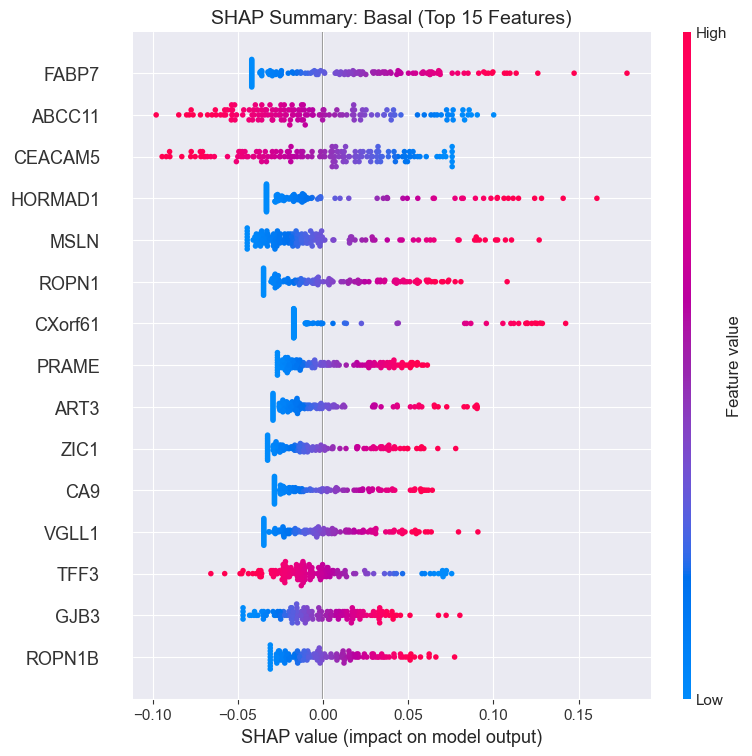

--------------------------------------------------
Generasi Plot untuk Kelas: Her2 ...


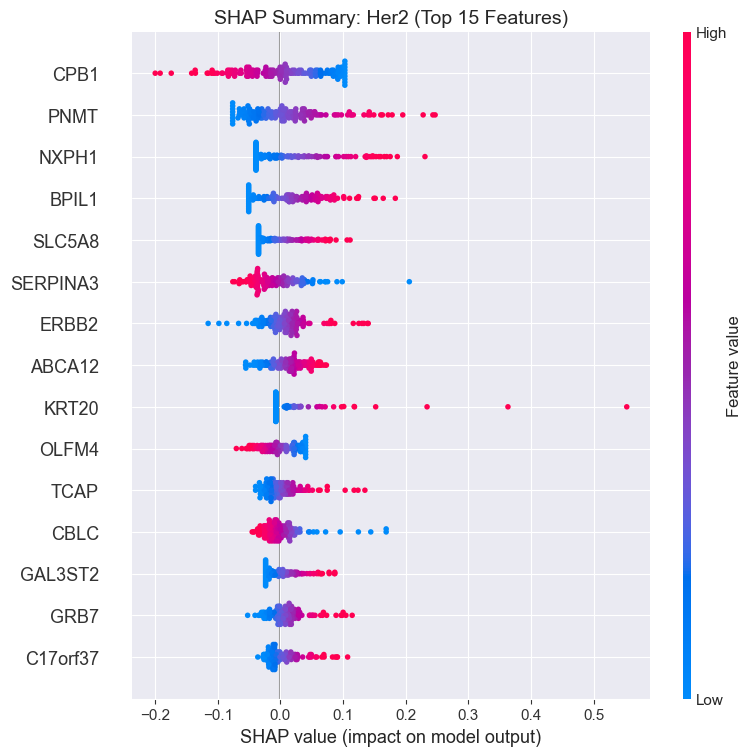

--------------------------------------------------
Generasi Plot untuk Kelas: LumA ...


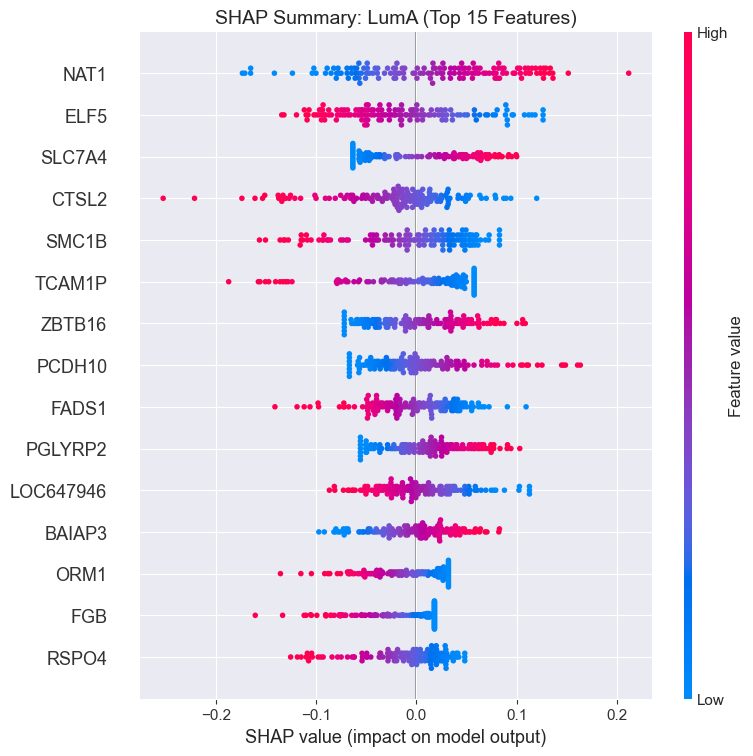

--------------------------------------------------
Generasi Plot untuk Kelas: LumB ...


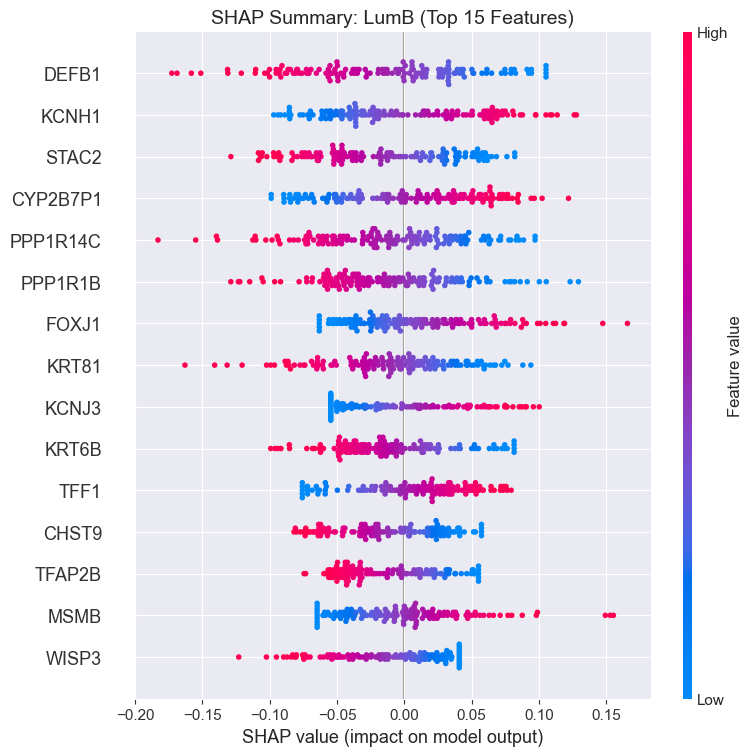

--------------------------------------------------
Generasi Plot untuk Kelas: Normal ...


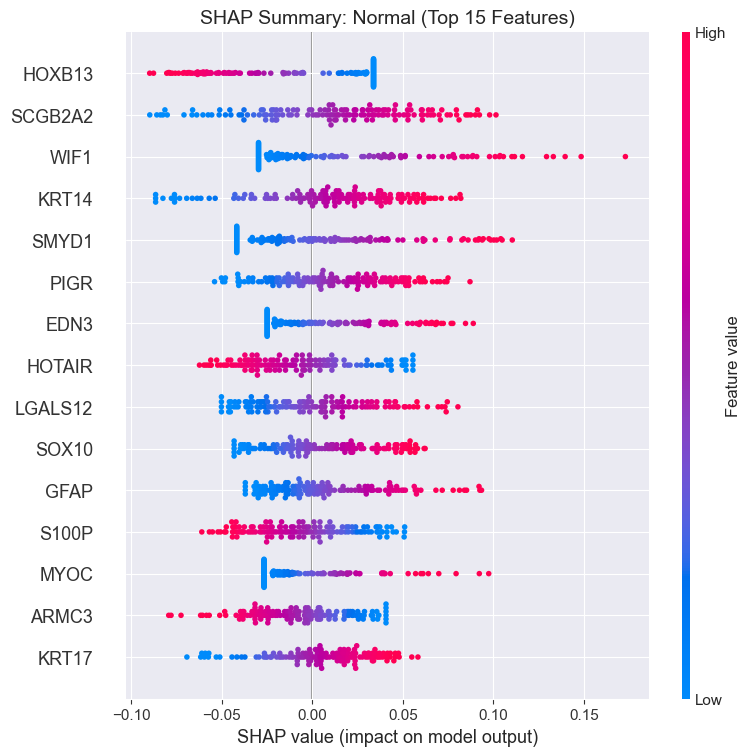

--------------------------------------------------


In [37]:
# 2. Plot SEMUA kelas sekaligus
# Pastikan variabel feature_cols dan le (LabelEncoder) sudah ada
plot_shap_summary(
    shap_values_calc,
    X_val_scaled,
    feature_names=feature_cols,
    class_names=le.classes_,
    target_class='all'
)


--- Analisis Pasien #1 untuk Kelas: Basal ---


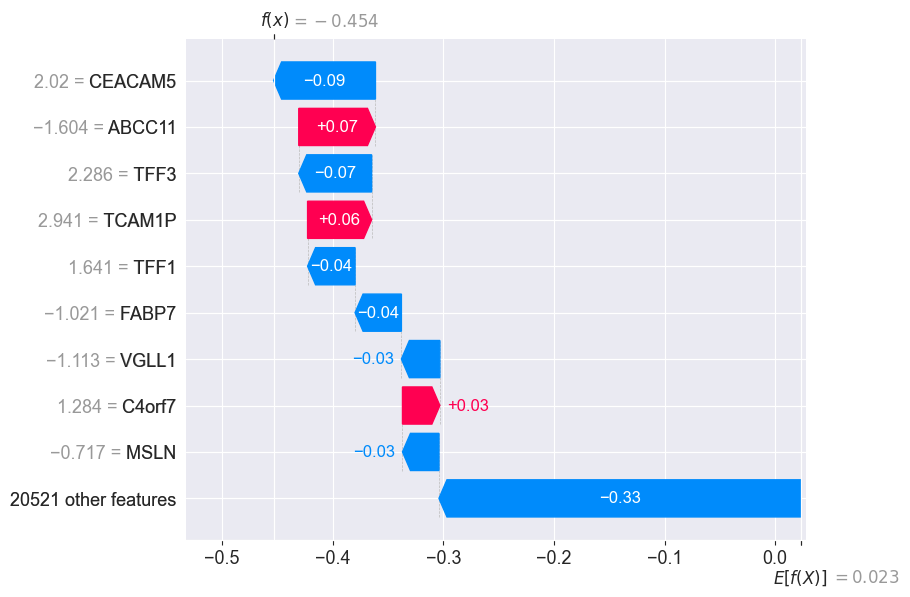

In [41]:
plot_shap_waterfall(
    shap_values=shap_values,      # Hasil perhitungan SHAP sebelumnya
    explainer=explainer,          # Objek explainer
    X_data=X_val_scaled,          # Data validasi
    feature_names=feature_cols,   # Nama-nama gen
    class_names=le.classes_,      # Nama kelas asli
    sample_idx=1,                 # Pasien pertama
    class_idx=0                   # Kelas Basal
)

In [28]:
 from sklearn.inspection import permutation_importance

# Hitung Permutation Importance (bisa agak lama karena diulang-ulang)
perm_importance = permutation_importance(lasso, X_val_scaled, y_val, n_repeats=10, random_state=42, n_jobs=-1)

# Ambil fitur terpenting
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

# Tampilkan Top 10
print("Top 10 Features by Permutation Importance:")
for i in sorted_idx[:10]:
    print(f"{feature_cols[i]}: {perm_importance.importances_mean[i]:.4f}")

Top 10 Features by Permutation Importance:
TCAM1P: 0.0112
TEX19: 0.0077
MYBL2: 0.0056
FABP7: 0.0056
PCSK2: 0.0049
PGLYRP2: 0.0049
FADS1: 0.0049
LOC647946: 0.0049
SLC7A4: 0.0049
CFB: 0.0042
